In [13]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from sklearn.linear_model import Ridge
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from monthlydf import train, test1, daily_revenue_df

In [14]:
#Train Features
holiday_dates = pd.to_datetime([
    '2011-01-01',  # New Year's Day
    '2011-01-17',  # Martin Luther King Jr. Day
    '2011-02-14',  # Valentine's Day
    '2011-02-21',  # Presidents' Day
    '2011-04-22',  # Good Friday
    '2011-04-24',  # Easter Sunday
    '2011-05-08',  # Mother's Day
    '2011-05-30',  # Memorial Day
    '2011-06-19',  # Father's Day
    '2011-07-04',  # Independence Day
    '2011-09-05',  # Labor Day
    '2011-10-10',  # Columbus Day
    '2011-10-31',  # Halloween
    '2011-11-11',  # Veterans Day
    '2011-11-24',  # Thanksgiving
    '2011-11-25',  # Black Friday
    '2011-11-28',  # Cyber Monday
    '2011-12-24',  # Christmas Eve
    '2011-12-25',  # Christmas Day
    '2011-12-26',  # Boxing Day
    '2011-12-31',  # New Year's Eve
])

def create_features_model(df):
    df = df.copy()
    df['days'] =  pd.to_datetime(df['days'])
    df['Quarter'] = df['days'].dt.quarter
    df['Day of Week'] = df['days'].dt.dayofweek
    df['InvoiceDate'] = df['days']
    df['Year'] = df['days'].dt.year
    df['Month'] = df['days'].dt.month
    df['Is Holiday'] = df['days'].isin(holiday_dates).astype(int)

    return df

train = create_features_model(train)
test = create_features_model(test1)

FEATURES = ['Day of Week', 'Month', 'Year', 'Is Holiday', 'Quarter']
TARGET = 'revenue'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [15]:
#Create Model
reg = xgb.XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',      # updated objective
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,                       # lower = less memorization
    subsample=0.8,                     # randomly sample rows
    colsample_bytree=0.8,              # randomly sample features
    reg_alpha=1,                       # L1 regularization (sparsity)
    reg_lambda=1,                      # L2 regularization (weight shrinking)
    early_stopping_rounds=50,
    verbosity=1
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:12317.47546


[100]	validation_0-rmse:9247.94804
[200]	validation_0-rmse:9014.86764
[222]	validation_0-rmse:9018.02167


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

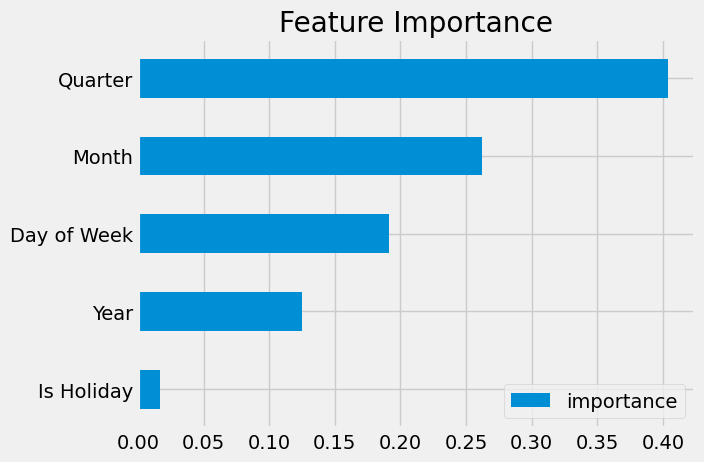

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

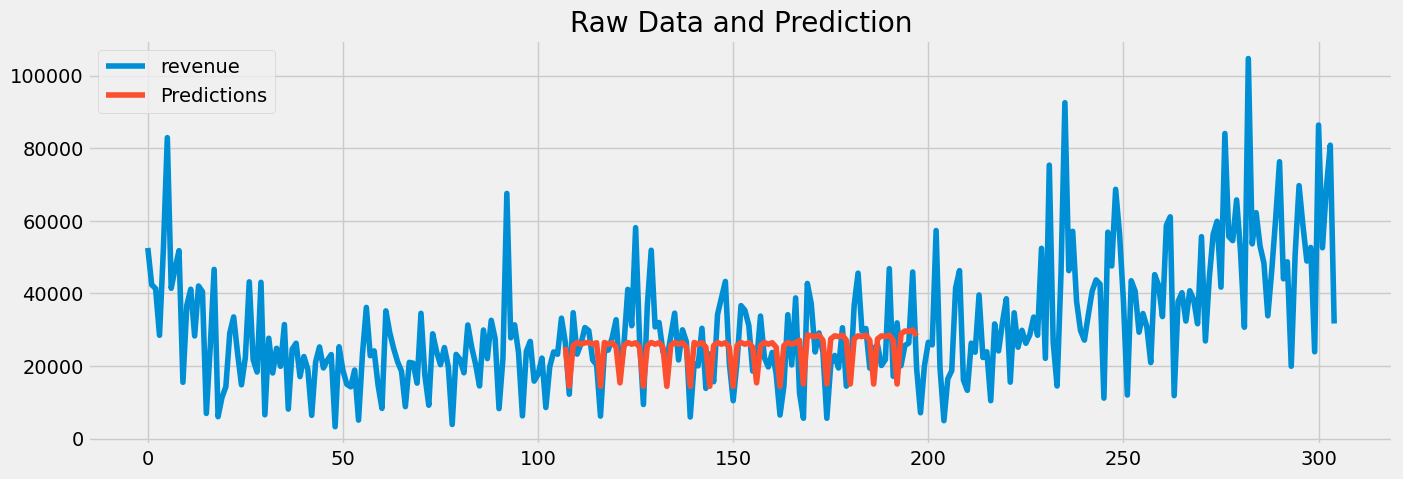

In [17]:
test['prediction'] = reg.predict(X_test)

test['days'] = pd.to_datetime(test1['days'])         
daily_revenue_df['days'] = pd.to_datetime(daily_revenue_df['days'])

if 'prediction' in daily_revenue_df.columns:
    daily_revenue_df = daily_revenue_df.drop(columns=['prediction'])

daily_revenue_df = daily_revenue_df.merge(
    test[['days', 'prediction']],
    on='days',
    how='left'
)

ax = daily_revenue_df[['revenue']].plot(figsize=(15, 5), label='Truth Data')
daily_revenue_df['prediction'].plot(ax=ax, label='Predictions')
plt.legend()
ax.set_title('Raw Data and Prediction')
plt.show()

In [18]:
score = np.sqrt(mean_squared_error(test['revenue'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 8981.91


In [19]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test.groupby(['days'])['error'].mean().sort_values(ascending=False).head(10)

days
2011-05-12    31721.530000
2011-05-17    25420.390547
2011-07-28    18313.833203
2011-07-19    17278.066250
2011-06-09    16904.060000
2011-07-31    16847.924336
2011-08-04    15985.434375
2011-05-10    14637.880547
2011-07-01    14509.910078
2011-07-04    14203.040469
Name: error, dtype: float64

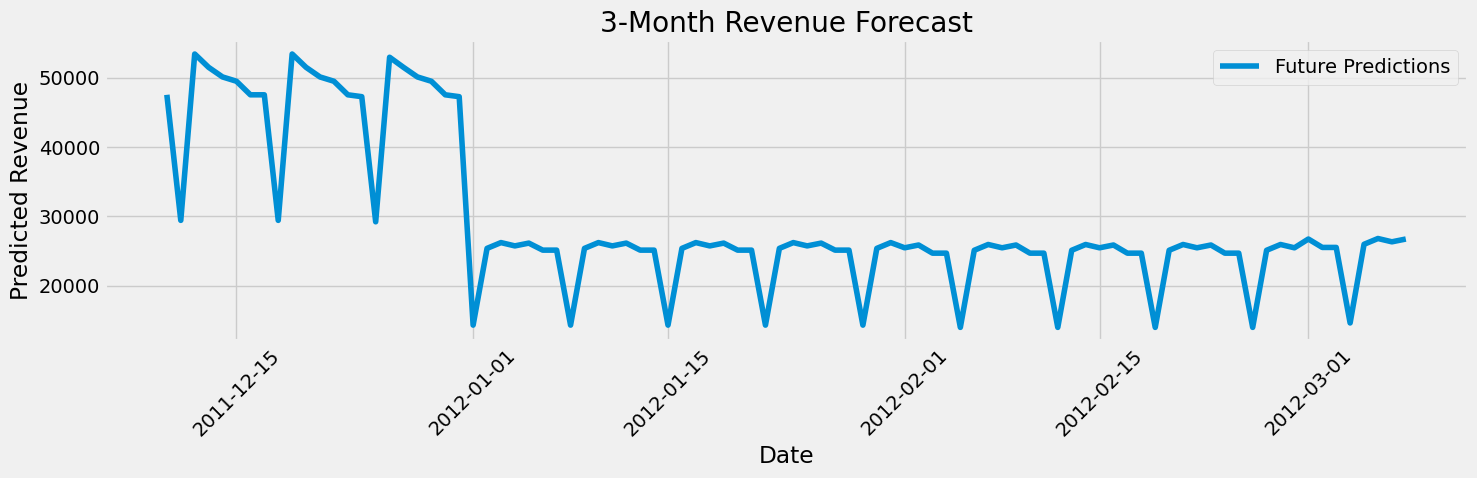

Total predicted revenue for the next 3 months: $2,659,394.25


In [20]:
last_date = daily_revenue_df['days'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

future_df = pd.DataFrame({'days': future_dates})

future_features = create_features_model(future_df)
X_future = future_features[FEATURES].astype(float)

future_df['prediction'] = reg.predict(X_future)

plt.figure(figsize=(15, 5))
plt.plot(future_df['days'], future_df['prediction'], label='Future Predictions')
plt.title('3-Month Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Predicted Revenue')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_future_revenue = future_df['prediction'].sum()
print(f"Total predicted revenue for the next 3 months: ${total_future_revenue:,.2f}")